## QPR problem solving using QCNN

**Quantum phase recognition (QPR)** asks whether a given input quantum state $\rho_{in}$ belongs to a particular quantum phase of matter. "We assume that $\rho_{in}$ is prepared in a physical system without direct access to its classical description."

Apply **quantum convolutional neural network (QCNN)** to QPR in a class oc 1D many-body systems. Specifically, a $\mathbb{Z}_2 \times \mathbb{Z}_2$ symmetry-protected topological (SPT) phase $\mathcal{P}$, a phsase containing the $S=1$ Haldane chain, and group state $\{ \Psi_G \}$ of a family of Hamiltonians on a spin-1/2 cahin with open boundary conditions: $$ \hat{H} = -J \sum_{i=1}^{N-2}(\hat{Z}_{i}\hat{X}_{i+1}\hat{Z}_{i+2}) -h_{1}\sum_{i=1}^{N}(\hat{X}_{i}) -h_{2}\sum_{i=1}^{N-1}(\hat{X}_{i}\hat{X}_{i+1}) $$ where $X_i, Z_i$ are Pauli operators for the spin at site $i$, and $h_1$, $h_2$ and $J$ are parameters of the Hamiltonian.

The authors begin by considering the ground state wavefunctions of a family of hamiltonians parameterized by $h_{1}, h_{2}$. The ground states of this system exist in certain  phases of matter (paramagnetic, antiferromagnetic, SPT) depnding on the values of $h_{1}, h_{2}$ ($J$ was set without loss of generality $J = 1$).
The authors then ask the question, is it possible for a quantum machine learning model to determine which state a of matter a particular wave function is from? The model used is the QCNN model they present in the paper.  

The training data set consists of 40 ground state wave functions for the hamiltonian with $h_{2} = 0$ and $h_{1}$ sampled at regular intervals between $[0, 1.6]$. The testing data set consists of (64 x 64) samples of $h_{2} \in [-1.5, 1.5]$ , $h_{1} \in [0, 1.6]$. The output of the Qcnn would be a real number between (-1, 1) (this was a measurement of the expectation of the pauli-X operator on the middle qubit). 

The ground truth phase boundaries between the SPT phase and the paramagnetic or anti-ferromagnetic phases was derived using DMRG simulations. Then the SPT phase was labeled 1 and the other two phases as 0. If the QCNN could correctly produce the correct label given the ground state wave function, then we would have successfuly learned how to distinguish between the quantum phases of matter! 


- Our goal is to identify a QCNN capable of distinguishing between SPT ($label=1$) and other phase ($label=0$).

## Date and Time Information
- When saving everything from model parameters to plot images, we will save its file name with the time information.y

In [1]:
import datetime

# Get the current date and time
current_datetime = datetime.datetime.now()

# Format the date and time as a string
date_time_str = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the object name
object_name = f"model_{date_time_str}"

# Now 'object_name' contains the desired name with date and time info
print(object_name)

model_20231224_174115


## Create result folder

In [2]:
import os

# Define the folder name
date_str = date_time_str[0:8]
result_folder_name = f'result_simul\{date_str}'

# Create the folder if it doesn't exist
if not os.path.exists(result_folder_name):
    os.makedirs(result_folder_name)

## Data

In [3]:
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt 

sys.path.insert(0, "qml_src/")

from qml import qcnn as q
from qml import layers as cl # custom layers 

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
from torch import manual_seed, tensor, Tensor, float32

In [4]:
num_qubits = 9
num_measurements = num_qubits

In [5]:
## read / import data 
training_fname = "./data_fldr/dataset_n={}_train.txt".format(num_qubits)
test_fname = "./data_fldr/dataset_n={}_test.txt".format(num_qubits)

def read_eigenvectors(file):
    with open(file, 'r+') as f:
        textData = f.readlines()

        h_vals = []
        for i in range(len(textData)):
            h1h2, eigenvector = textData[i].split("_")

            h_vals.append(tuple(map(float, h1h2[1: -1].split(', '))))
            textData[i] = eigenvector

        return h_vals, np.loadtxt(textData, dtype=complex)

h1h2_train, train_data = read_eigenvectors(training_fname)
h1h2_test, test_data = read_eigenvectors(test_fname)

# To get the correct labels of the training set we use the fact that data points with
# h1 <= 1 are in the SPT phase and thus assigned the label 1 while h1 > 1 are in the paramagnetic phase 
# This is only true for the training set which has h2 = 0 for all samples, 

labels = np.zeros(40)
test_labels = np.zeros(4096)


for index, h1h2 in enumerate(h1h2_train):
    h1, h2 = h1h2
    if h1 <= 1:
        # Label = 1: SPT phase, and Label = 0: Other two phases 
        labels[index] = 1.0
    # else:
        # Label = 1: SPT phase, and Label = -1: Other two phases 
        # labels[index] = -1.0

In [6]:
# Function that calculates the shape of a coordinate_list
def get_shape_of_coordinate_list(coord_list):
    num_rows = len(coord_list)
    num_columns = 0

    if num_rows > 0:
        num_columns = len(coord_list[0])

    for coordinate in coord_list:
        if len(coordinate) != num_columns:
            raise ValueError("The list does not have a consistent number of columns.")

    return num_rows, num_columns

# We have a list of h1 & h2 values of train / test data.
print("h1h2_train:")
print(type(h1h2_train))
print(f"The shape of the list is {get_shape_of_coordinate_list(h1h2_train)}.")
print()
print("h1h2_test:")
print(type(h1h2_test))
print(f"The shape of the list is {get_shape_of_coordinate_list(h1h2_test)}.")

h1h2_train:
<class 'list'>
The shape of the list is (40, 2).

h1h2_test:
<class 'list'>
The shape of the list is (4096, 2).


In [7]:
h1h2_train[0:5]

[(0.0, 0.0),
 (0.041025641025641026, 0.0),
 (0.08205128205128205, 0.0),
 (0.12307692307692308, 0.0),
 (0.1641025641025641, 0.0)]

In [8]:
# Also, we have two arrays of the quantum states of train / test data.
print("train_data:")
print(type(train_data))
print(f"The shape of the data is {train_data.shape}.")
print()
print("test_data:")
print(type(test_data))
print(f"The shape of the data is {test_data.shape}.")

train_data:
<class 'numpy.ndarray'>
The shape of the data is (40, 512).

test_data:
<class 'numpy.ndarray'>
The shape of the data is (4096, 512).


In [9]:
# Count the complex numbers that has imaginary number value equal to zero.
print("train_data:")
print(sum(sum(train_data.imag==0)))
print(f"Is all the coefficients are real numbers? The answer is ({sum(sum(train_data.imag==0)) == train_data.shape[0]*train_data.shape[1]}).")
print()
print("test_data:")
print(sum(sum(test_data.imag==0)))
print(f"Is all the coefficients are real numbers? The answer is ({sum(sum(test_data.imag==0)) == test_data.shape[0]*test_data.shape[1]}).")

train_data:
20480
Is all the coefficients are real numbers? The answer is (True).

test_data:
2097152
Is all the coefficients are real numbers? The answer is (True).


- You would find that all the `txt` file that has the amplitude values are all real values, not complex values.
- So, when we are making Train / Test dataset for `PyTorch`, we will upload those values as *`float`*.

In [10]:
# Label of the train and test data of quantum states.
print(type(h1h2_train))
print(len(h1h2_train))
print(h1h2_train[0:5])
print()
print(type(h1h2_test))
print(len(h1h2_test))
print(h1h2_test[0:5])
print()
print(type(labels))
print(len(labels))
print(labels)

<class 'list'>
40
[(0.0, 0.0), (0.041025641025641026, 0.0), (0.08205128205128205, 0.0), (0.12307692307692308, 0.0), (0.1641025641025641, 0.0)]

<class 'list'>
4096
[(0.0, -1.6), (0.0, -1.5492063492063493), (0.0, -1.4984126984126984), (0.0, -1.4476190476190478), (0.0, -1.396825396825397)]

<class 'numpy.ndarray'>
40
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
# Input quantum state of the train and test data of quantum states.
print(type(train_data))
print(len(train_data))
print(train_data.shape)
print(train_data[0:5])
print()
print(type(test_data))
print(len(test_data))
print(test_data.shape)
print(test_data[0:5])

<class 'numpy.ndarray'>
40
(40, 512)
[[-0.06749047+0.j -0.05629773+0.j -0.06749047+0.j ...  0.00905865+0.j
  -0.0024584 +0.j  0.00905865+0.j]
 [-0.06841683+0.j -0.00275042+0.j -0.06704252+0.j ... -0.06704252+0.j
  -0.00275042+0.j -0.06841683+0.j]
 [-0.07462464+0.j -0.00588162+0.j -0.07169177+0.j ... -0.07169177+0.j
  -0.00588162+0.j -0.07462464+0.j]
 [ 0.08110839+0.j  0.00940343+0.j  0.07643609+0.j ...  0.07643609+0.j
   0.00940343+0.j  0.08110839+0.j]
 [-0.0878373 +0.j -0.01332044+0.j -0.08125316+0.j ... -0.08125316+0.j
  -0.01332044+0.j -0.0878373 +0.j]]

<class 'numpy.ndarray'>
4096
(4096, 512)
[[ 0.05074506+0.j  0.05136141+0.j -0.03014733+0.j ... -0.03119055+0.j
   0.05209155+0.j  0.04969072+0.j]
 [ 0.06205576+0.j  0.0429737 +0.j -0.01758693+0.j ... -0.04119365+0.j
   0.05928122+0.j  0.03806589+0.j]
 [-0.00699659+0.j -0.06762913+0.j  0.05948994+0.j ... -0.0111418 +0.j
  -0.01952419+0.j -0.07922385+0.j]
 [-0.01299619+0.j  0.06759939+0.j -0.06648151+0.j ...  0.02838657+0.j
   0.00398

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

# Train Dataset
# -------------

# Define your custom dataset class
class MyDataset_train(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 5
# n_samples = len(train_data)

# Convert data and labels to tensors
data_tensor = torch.tensor(train_data, dtype=torch.float)
label_tensor = torch.tensor(labels, dtype=torch.float)

# Create an instance of your custom dataset
train_dataset = MyDataset_train(data_tensor, label_tensor)

# Define torch DataLoader with the data
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

C:\Users\user\AppData\Local\Temp\ipykernel_25324\3503074924.py:26: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ..\aten\src\ATen\native\Copy.cpp:276.)
  data_tensor = torch.tensor(train_data, dtype=torch.float)


- The <font color="blue">*"UserWarning: Casting complex values to real discards the imaginary part"*</font> is okay, since we have checked that all the imaginary number are equal to zero.

- Why have we taking this work process?
    - It was neccesary since all the raw files from `txt` are saved in complex data type.

In [13]:
type(train_dataset)

__main__.MyDataset_train

In [14]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [15]:
print(train_dataset.data)
print(train_dataset.data.shape)
print()
print(train_dataset.targets)
print(train_dataset.targets.shape)
print()
print(train_loader)

tensor([[-0.0675, -0.0563, -0.0675,  ...,  0.0091, -0.0025,  0.0091],
        [-0.0684, -0.0028, -0.0670,  ..., -0.0670, -0.0028, -0.0684],
        [-0.0746, -0.0059, -0.0717,  ..., -0.0717, -0.0059, -0.0746],
        ...,
        [ 0.1037,  0.0769,  0.0844,  ...,  0.0844,  0.0769,  0.1037],
        [-0.1021, -0.0762, -0.0833,  ..., -0.0833, -0.0762, -0.1021],
        [ 0.1005,  0.0756,  0.0823,  ...,  0.0823,  0.0756,  0.1005]])
torch.Size([40, 512])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
torch.Size([40])



In [16]:
# Test Dataset
# -------------

# Define your custom dataset class
class MyDataset_test(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
# Set test shuffle seed (for reproducibility)
manual_seed(7)

# n_samples = len(test_data)

# Convert test data to a tensor
test_data_tensor = torch.tensor(test_data, dtype=torch.float)

# Create an instance of your custom dataset for test data
test_dataset = MyDataset_test(test_data_tensor)

# Define DataLoader for test data
test_batch_size = 5  # Use the batch size you prefer for testing
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)  # No need to shuffle test data

In [17]:
print(test_data_tensor)
print(test_data_tensor.shape)

tensor([[ 0.0507,  0.0514, -0.0301,  ..., -0.0312,  0.0521,  0.0497],
        [ 0.0621,  0.0430, -0.0176,  ..., -0.0412,  0.0593,  0.0381],
        [-0.0070, -0.0676,  0.0595,  ..., -0.0111, -0.0195, -0.0792],
        ...,
        [ 0.0628,  0.0556,  0.0579,  ...,  0.0579,  0.0556,  0.0628],
        [ 0.0623,  0.0554,  0.0576,  ...,  0.0576,  0.0554,  0.0623],
        [-0.0619, -0.0552, -0.0573,  ..., -0.0573, -0.0552, -0.0619]])
torch.Size([4096, 512])


## Import code related to quantum / `qclib`

In [18]:
import numpy as np
from torch import tensor
from torch.nn import CrossEntropyLoss, MSELoss
# from dataset.mnist import get_data as get_mnist
from qiskit.providers.fake_provider import (
    FakeVigo,
    FakeJakarta,
    FakeGuadalupe,
    FakeKolkata,
    FakeMumbai
)

# If you are not using the `qdna-lib` source code,
# comment out the following two lines.
import sys
sys.path.append('qdna-lib/')

from qdna.embedding import (
    AeFeatureMap,
)
from qdna.ansatz import (
    Qcnn,
    ConvSimple,
    PoolSimple
)

## Configuration of the model structure

In [19]:
print(num_qubits)
print(num_measurements)

feature_map_type = AeFeatureMap
conv_block_type = ConvSimple
pool_block_type = PoolSimple
noisy_device_type = None # FakeVigo, FakeJakarta, FakeGuadalupe, FakeKolkata, FakeMumbai, etc (None=ideal simulation)
# get_dataset = get_mnist # get_mnist, get_fashion_mnist, get_cifar10 (see files in the folder 'dataset')
loss_func = CrossEntropyLoss() # MSELoss(), CrossEntropyLoss()
epochs = 10
batch_size = 10

num_features = feature_map_type(num_qubits, reps=1).num_parameters_settable

9
9


In [20]:
print('num_qubits:', num_qubits)
print('feature_map_type:', feature_map_type)
print('conv_block_type:', conv_block_type)
print('pool_block_type:', pool_block_type)
print('noisy_device_type:', noisy_device_type)
print()
print('loss_func:', loss_func.__class__.__name__)
print('epochs:', epochs)
print('batch_size:', batch_size)
print()
print('num_feature:', num_features)

num_qubits: 9
feature_map_type: <class 'qdna.embedding.ae_feature_map.AeFeatureMap'>
conv_block_type: <class 'qdna.ansatz.qcnn.ConvSimple'>
pool_block_type: <class 'qdna.ansatz.qcnn.PoolSimple'>
noisy_device_type: None

loss_func: CrossEntropyLoss
epochs: 10
batch_size: 10

num_feature: 512


## Device and Primitives (Sampler or Estimator)

In [21]:
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendSampler

if noisy_device_type is None:
    # Local exact count simulation
    sampler = None
else:
    # Local noisy simulation
    noisy_backend = noisy_device_type()
    sampler = BackendSampler(backend = noisy_backend)

In [22]:
# example from:
# https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html

from qiskit_aer.noise import pauli_error

def create_noise_model():
    # Example error probabilities
    p_reset = 0.03
    p_meas = 0.1
    p_gate1 = 0.0000001 # 5

    # QuantumError objects
    error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate2 = error_gate1.tensor(error_gate1)

    # Add errors to noise model
    noise_bit_flip = NoiseModel()
    #noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
    #noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
    noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    #noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

    return noise_bit_flip

## Define and create the quantum circuit

In [23]:
# Hyper-parameter of the QCNN circuit
print('num_qubits:', num_qubits)  # int(np.log2(train_data.shape[1]))
traditional_qcnn=True

if traditional_qcnn:
    num_meas = 1
else:
    num_meas = num_qubits

num_qubits: 9


In [24]:
print("Number of qubits:", num_qubits)
print('traditional_qcnn:', traditional_qcnn)
print("Number of measuring qubits:", num_meas)

Number of qubits: 9
traditional_qcnn: True
Number of measuring qubits: 1


In [25]:
# # Define and create QNNs
# from qiskit import QuantumCircuit, ClassicalRegister, transpile
# from qiskit.utils import algorithm_globals
# from qiskit_machine_learning.neural_networks import SamplerQNN
# from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
# from qiskit_machine_learning.circuit.library import RawFeatureVector
# from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap

# Define and create QNNs
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.circuit import ClassicalRegister, QuantumRegister, QuantumCircuit, Parameter, ParameterVector, Gate
from QCNN_cong_custom_circuit import (
    two_qubit_unitary_U, two_qubit_unitary_U_endpoint, uniformly_control_ry, uniformly_control_rz, three_qubit_unitary_decomposition, conv_SU4, conv_U1_block, conv_U2_block, conv_U3_block, conv_U4_block, Pooling_gate, Pooling_block, Fully_Connected_block, QCNN_Cong_qubit_ansatz
)

In [26]:
algorithm_globals.random_seed = 12345

def null_interpret(x):
    # To define `output_shape` we must also define an `interpret` function,
    # even if it do nothing. If `output_shape` is not defined, the measurement
    # will always return an array with 2^n quasi-probabilities, padding with
    # zeroes the amplitudes not associated with measured qubits.
    return x

# def place_measurements(qc):
#     cbit = 0
#     block_size = num_qubits
#     while block_size > 1:
#         qbit = num_qubits - block_size
#         qc.measure(qbit, cbit)
#         cbit += 1
#         block_size = int(np.ceil(block_size / 2))

# Build QCNN circuit
def QCNN_Cong_circuit(feature_maps='AeFeatureMap', traditional_qcnn=False):
    # Feature map
    if feature_maps == 'AeFeatureMap':
        feature_map = feature_map_type(num_qubits, reps=1)
    
    # Ansatz
    ansatz = QCNN_Cong_qubit_ansatz(num_qubits, traditional_qcnn=traditional_qcnn)
   
    # Compose Circuit
    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True, wrap=True)
    qc.barrier()
    qc.compose(ansatz, inplace=True)
    
    if num_qubits==9:
        if traditional_qcnn:
            qc.add_register(ClassicalRegister(size=1))
            qc.h(4)
            qc.measure(4, 0)
            output_shape=2
        else:
            qc.add_register(ClassicalRegister(size=num_qubits))
            qc.h(range(num_qubits))
            qc.measure(np.array(range(num_qubits)), np.array(range(num_qubits)))
            output_shape=2**(num_qubits)

    if num_qubits==8:
        if traditional_qcnn:
            # qc.add_register(ClassicalRegister(size=1))
            qc.h(6)
            qc.measure(6, 0)
            output_shape=2
        else:
            # qc.add_register(ClassicalRegister(size=num_qubits))
            qc.h(range(num_qubits))
            qc.measure(np.array(range(num_qubits)), np.array(range(num_qubits)))
            output_shape=2**(num_qubits)
            
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        sampler=sampler,
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        interpret=null_interpret,
        output_shape=output_shape
    )

    return feature_map, ansatz, qc, qnn


# qc_traditional, qnn_traditional = create_qnn(feature_map='TopDownInitialize', traditional_qcnn=True)
feature_map_new, ansatz_new, qc_new, qnn_new = QCNN_Cong_circuit(feature_maps='AeFeatureMap', traditional_qcnn=False)

feature_map_traditional, ansatz_traditional, qc_traditional, qnn_traditional = QCNN_Cong_circuit(feature_maps='AeFeatureMap', traditional_qcnn=True)

# qnn_new = QCNN_Cong_8qubit_circuit()
# qnn_traditional = QCNN_Cong_9qubit_circuit(traditional_qcnn=True)

KeyboardInterrupt: 

In [ ]:
# Assign display styles of the gates in a circuit.draw
circuit_draw_style = style={'displaycolor': {'AeFeatureMap': ('#9f1952', '#FFFFFF'),
                                             'conv_SU4': ('#0196fe', '#000000'),
                                             'U1': ('#0196fe', '#000000'),
                                             'U2': ('#0196fe', '#000000'),
                                             'U3': ('#0196fe', '#000000'),
                                             'U4': ('#0196fe', '#000000'),
                                             'P1': ('#fe7e78', '#000000'),
                                             'Pooling': ('#fe7e78', '#000000'),
                                             'FC': ('#b587f7', '#000000')},
                            'creglinestyle': 'dashdot'}

In [ ]:
qnn_new

In [ ]:
print(type(feature_map_new))
print(type(ansatz_new))
print(type(qc_new))
print(type(qnn_new))

<class 'qdna.embedding.ae_feature_map.AeFeatureMap'>
<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
<class 'qiskit_machine_learning.neural_networks.sampler_qnn.SamplerQNN'>


circuit depth: 11
circut parameters: 809
The number of Encoding parameters: 512
The number of circuit parameters: 297


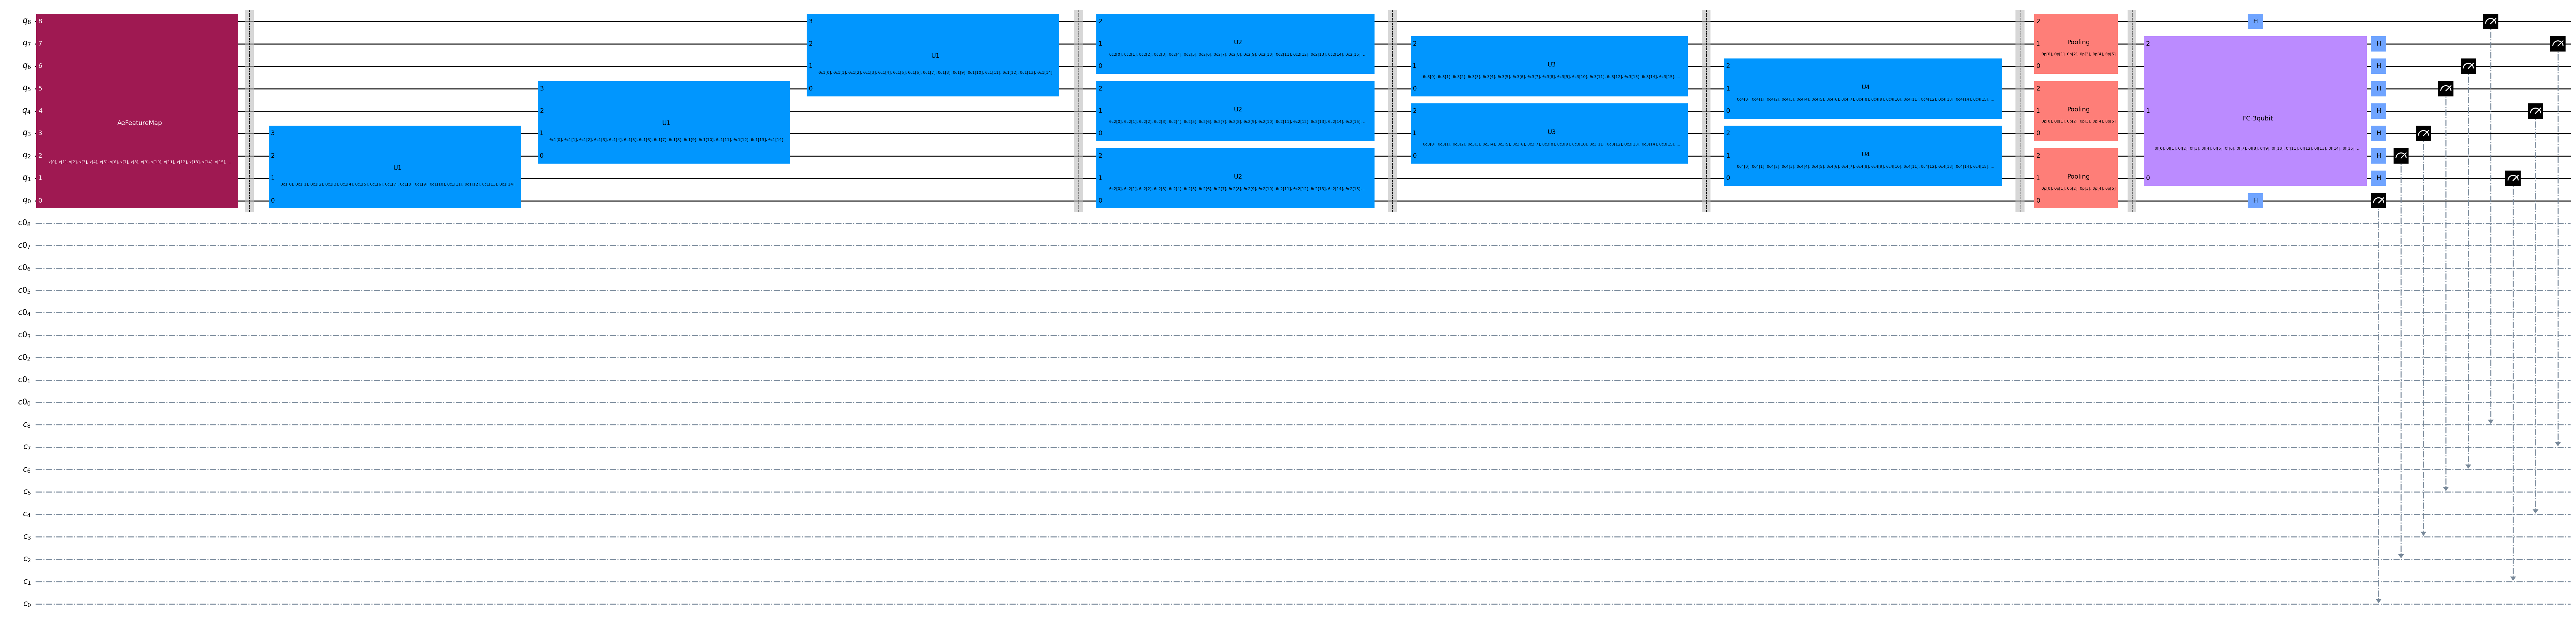

In [ ]:
# Draw the quantum circuit and calculate the circuit depth.
circuit = qc_new    # qc_new, qc_traditional
circuit_depth = circuit.depth()
circut_params = circuit.num_parameters
print("circuit depth:", circuit_depth)
print("circut parameters:", circut_params)
print("The number of Encoding parameters:", 2**num_qubits)
print("The number of circuit parameters:",  circuit.num_parameters-2**num_qubits)

circuit.draw('mpl', reverse_bits=True, style=circuit_draw_style, fold=-1)
# circuit.draw('mpl')
# circuit.decompose().draw('mpl', fold=-1)

## Define torch NN module

In [31]:
# Define torch NN module
from torch import concat, sum as tsum
from torch.nn import (
    Module,
    Linear,
    Sequential,
    CELU,
    Sigmoid
)
from qiskit_machine_learning.connectors import TorchConnector

def get_counts(x, num_measurements):
    # Calculates the probability of measuring zero on each qubit
    # separately from the measurement probability vector.

    size = 2**(num_measurements)

    idx = [v for i, v in enumerate(range(size)) if i % 2 < 1]
    new_x = tsum(x[:,idx], 1, True)

    for bit in range(1, num_measurements):
        idx = [v for i, v in enumerate(range(size)) if i % 2**(bit+1) < 2**bit]
        new_x = concat([new_x, tsum(x[:,idx], 1, True)], 1)

    return new_x

class Net(Module):
    def __init__(self, qnn, layers_sizes, traditional_qcnn=False):
        input_size, hidden_size, output_size = layers_sizes
        super().__init__()
        if not traditional_qcnn:
            self.linear_stack = Sequential(
                Linear(input_size, hidden_size),
                CELU(),
                Linear(hidden_size, hidden_size),
                CELU(),
                Linear(hidden_size, output_size),
                Sigmoid()
            )
        self.qnn = TorchConnector(qnn)
        self._traditional_qcnn = traditional_qcnn

    def forward(self, x):
        if self._traditional_qcnn:
            x = get_counts(self.qnn(x), num_measurements=1)
        else:
            x = get_counts(self.qnn(x), num_measurements=num_qubits)
            # x = x.float()  # Convert to float32 OR x.double()  # Convert to float64
            x = self.linear_stack(x)
        # Uncomment the line below to visually follow the convergence.
        # print(x.reshape(-1))
        return x.reshape(-1)

input_size = num_measurements
layers_sizes = (input_size, 3 * input_size, 1)

In [32]:
print(input_size)
print(layers_sizes)

9
(9, 27, 1)


## Training

In [33]:
import torch.optim as optim
from torch import save

def training(model, train_loader):
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Start training
    loss_list = [] # Store loss history
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.squeeze()
            target = target.float()

            optimizer.zero_grad(set_to_none=True) # Initialize gradient
            output = model(data)                  # Forward pass
            loss = loss_func(output, target)      # Calculate loss
            loss.backward()                       # Backward pass
            optimizer.step()                      # Optimize weights
            total_loss.append(loss.item())        # Store loss

        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

    return loss_list

def save_training_data(model, loss_list, file_suffix):
    save(model.state_dict(), f"./save/model_dict_{file_suffix}.pt")

    with open(f"./save/loss_list_{file_suffix}.txt",'w') as f:
        np.savetxt(f, loss_list, delimiter=",")

### train new model

In [34]:
model_new = Net(qnn_new, layers_sizes)
loss_list_new = training(model_new, train_loader)

QiskitError: 'Some classical bits are not used for measurements. the number of classical bits (18), the used classical bits ({0, 1, 2, 3, 4, 5, 6, 7, 8}).'

In [ ]:
# Assuming 'data_loader' is your DataLoader instance
for data, target in train_loader:
    print(data.dtype)
    print(target.dtype)
    break

In [ ]:
save_training_data(model_new, loss_list_new, 'new')

### train traditional model (comparison basis)

In [ ]:
model_traditional = Net(qnn_traditional, layers_sizes, traditional_qcnn=True)
loss_list_traditional = training(model_traditional, train_loader)

In [ ]:
save_training_data(model_traditional, loss_list_traditional, 'traditional')

## Plot training history

In [ ]:
# Plot loss convergence
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc

new_model_data = np.loadtxt(
    './save/loss_list_new.txt', delimiter=','
)

traditional_model_data = np.loadtxt(
    './save/loss_list_traditional.txt', delimiter=','
)

r = list(range(epochs))

# Data
df=pd.DataFrame(
    { 'x_values': r, 'QCNN': traditional_model_data,
      'AQCNN': new_model_data,      
    }
)

# multiple line plots
plt.plot( 'x_values', 'QCNN' , data=df, marker='o', markersize=8)
plt.plot( 'x_values', 'AQCNN' , data=df, marker='^', markersize=8)

plt.title("Hybrid NN training convergence")
plt.xlabel("Training iterations")
plt.ylabel("Loss")
plt.xticks(r)
plt.legend()
plt.show()

## Testing

In [ ]:
from torch import load

model_new_2 = Net(qnn_new, layers_sizes)
model_new_2.load_state_dict(load("./save/model_dict_new.pt"))

model_traditional_2 = Net(qnn_traditional, layers_sizes, traditional_qcnn=True)
model_traditional_2.load_state_dict(load("./save/model_dict_traditional.pt"))

In [ ]:
def test_model(model, test_loader):
    from torch import no_grad
    
    #loss_func = CrossEntropyLoss()
    #loss_func = MSELoss()

    model.eval()  # set model to evaluation mode
    with no_grad():
        total_loss = []
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.squeeze()
            # target = tensor(target, dtype=float32)
            target = target.float()

            output = model(data)

            pred = np.round(output, 0)
            # # Uncomment the line below to visually follow the test.
            # print('pred', pred)
            # print('target', target)

            correct += pred.eq(target.view_as(pred)).sum().item()

            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
            )
        )

In [ ]:
test_model(model_new_2, test_loader)

In [ ]:
test_model(model_traditional_2, test_loader)

### Plot a couple of tests

In [ ]:
def plot_test_model(model, test_loader):
    # Plot predicted labels
    from torch import no_grad
    import matplotlib.pyplot as plt

    n_samples_show = 6
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

    model.eval()
    with no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.squeeze()
            target = target.float()
            if count == n_samples_show:
                break
            output = model(data)
            
            pred = np.round([output[0]], 0)

            axes[count].imshow(
                data[0].numpy().reshape(
                    len(data[0])//int(np.floor(np.sqrt(len(data[0])))),
                    int(np.floor(np.sqrt(len(data[0]))))
                ),
                cmap="gray"
            )

            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title("Tgt {} Pred {}".format(int(target[0]), int(pred.item())))

            count += 1

In [ ]:
plot_test_model(model_new_2, test_loader)